In [13]:
os.getcwd()

'/home/s/ss/323/q323ss/Renel'

In [40]:
!pip install gtrends

Data For the stock market can be downloaded from here: https://finance.yahoo.com/. Recommended to download this instead of using the provided CSV for the most recent data

In [43]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import os
import gtrends 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper

# Additional Features
from pytrends.request import TrendReq
# from utils import get_daily_trend
from pytrends import dailydata

In [14]:
google = pd.read_csv('time series data/GOOG.csv')
google.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
3,2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276


In [15]:
def get_stats(df):
    start_date = datetime.datetime.strptime(df['Date'].min(), '%Y-%m-%d')
    end_date = datetime.datetime.strptime(df['Date'].max(), '%Y-%m-%d')
    data_duration = (end_date - start_date).days

    print(f"Start Date: {df['Date'].min()}")
    print(f"End Date: {df['Date'].max()}")
    print(f"Date Difference: {data_duration}")
    print(f"Number of Data Points: {df.shape[0]}")

In [16]:

get_stats(google)

Start Date: 2004-08-19
End Date: 2021-08-17
Date Difference: 6207
Number of Data Points: 4279


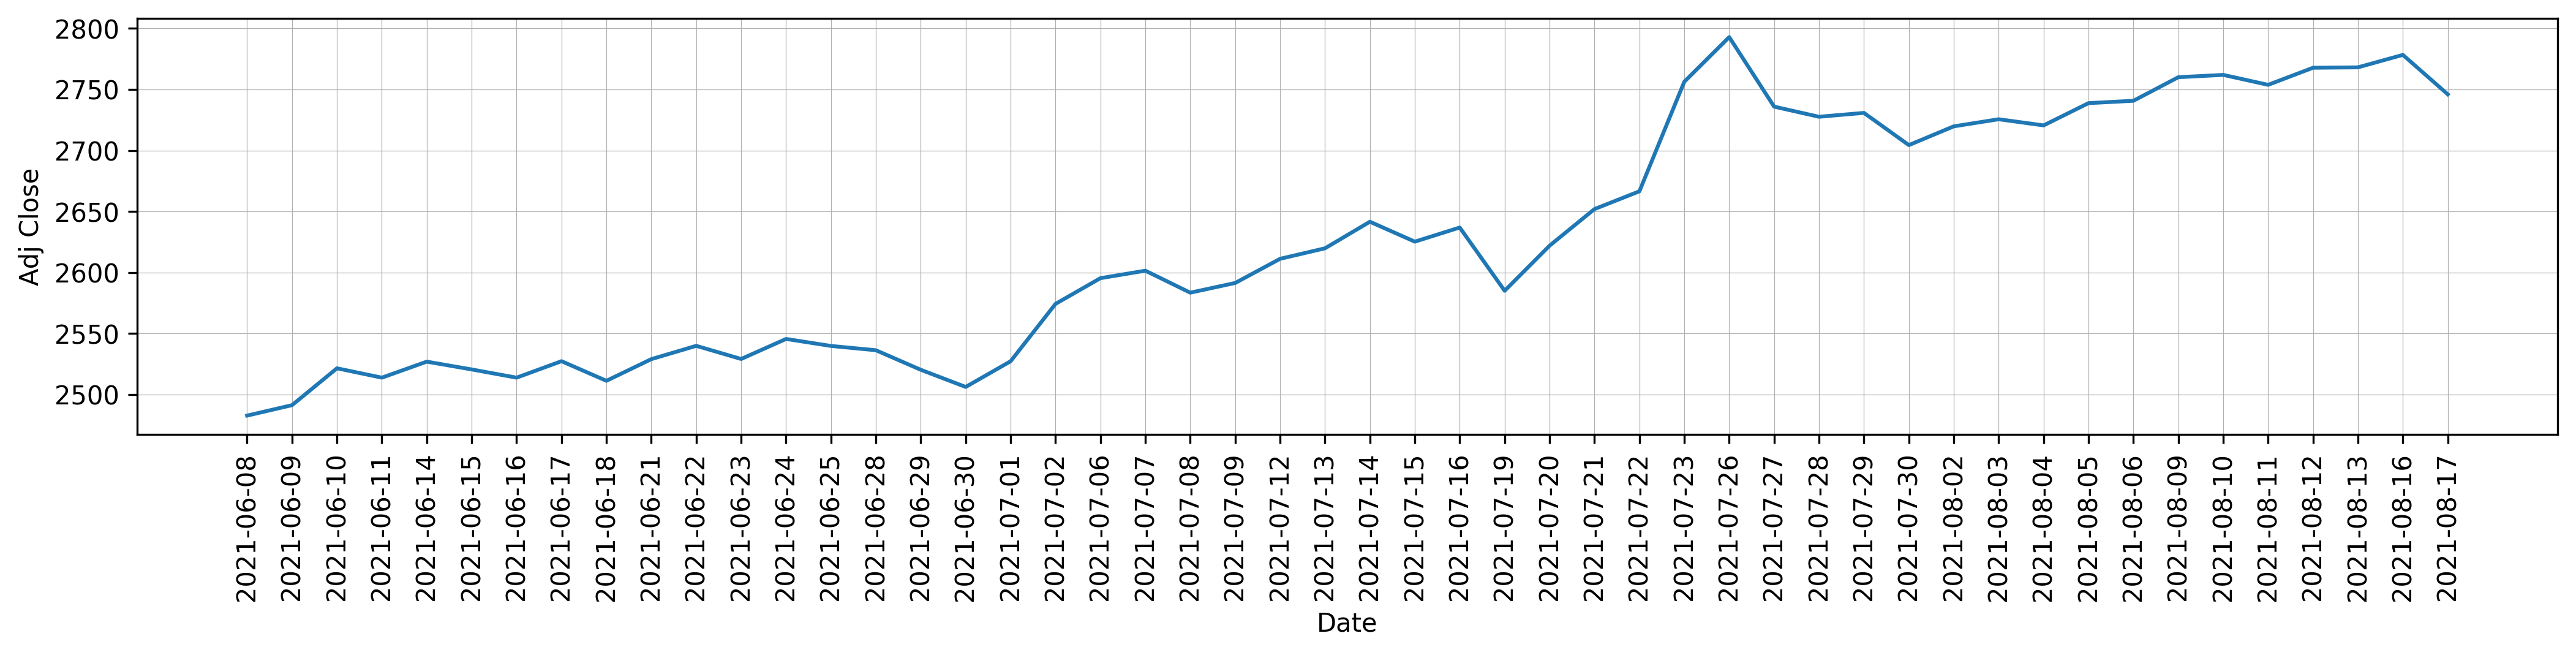

In [18]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=google.tail(50), x='Date', y='Adj Close')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

### Feature Engineering
Let's see how far we can get with:

1.Lagged Ajusted Close price

2.Previous day's volume

3.Day of week

In [20]:

google.columns = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume']
google['prev_adjusted_close'] = google['adjusted_close'].shift(1)
google['prev_volume'] = google['volume'].shift(1)
google['day_of_week'] = pd.to_datetime(google['date']).dt.dayofweek
data = google[['date', 'adjusted_close', 'prev_adjusted_close', 'prev_volume', 'day_of_week']].dropna()
data.sample()

,date,adjusted_close,prev_adjusted_close,prev_volume,day_of_week
1908,2012-03-16,311.352966,309.405273,4888455.0,4


In [21]:
categorical_features = ['day_of_week']
numerical_features = ['prev_adjusted_close', 'prev_volume']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [StandardScaler()]) for n in numerical_features]
cat = [([n], [OrdinalEncoder()]) for n in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.755e+06
Date:                Wed, 18 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:41:56   Log-Likelihood:                -13936.
No. Observations:                3850   AIC:                         2.788e+04
Df Residuals:                    3846   BIC:                         2.791e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 485.7033      0.256   1897.163      0.000     485.201     486.205
prev_adjusted_close   334.1837      0.175   1911.709      0.000     333.841     334.526
prev_volume            -0.0951      0.175     -0.544      0.586      -0.438       0.248
day_of_week             0.0476      0.104      0.457      0.648      -0.156       0.252
==============================================================================
Omnibus:                     1016.980   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75653.542
Skew:                           0.229   Prob(JB):                         0.00
Kurtosis:                      24.712   Cond. No.                         4.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Let's leave in prev_volume. If taken alone, it shows significance. The linear regression model may not be complex enough to capture contribution by prev_volume

## Train Model

In [23]:
def evaluation(pipeline, X, y):
    y_prediction = pipeline.predict(X)
    return{
        'MAE': mean_absolute_error(y, y_prediction),
        'MAPE': mean_absolute_percentage_error(y, y_prediction),
        'y_pred': y_prediction
    }

In [24]:
mapper = DataFrameMapper(num + cat, df_out=True)
clf = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('clf', clf)
])

pipeline.fit(X_train, y_train)
results = evaluation(pipeline, X_test, y_test)
print(f"MAE: ${round(results['MAE'], 2)}, MAPE: {round(results['MAPE'] * 100, 2)}%")

MAE: $22.86, MAPE: 1.4%


In [25]:
google_forecast = pd.DataFrame(data={
    'date': test_df['date'].reset_index().drop('index', axis=1)['date'],
    'predictions': results['y_pred'],
    'truth': y_test.reset_index().drop('index', axis=1)['adjusted_close']})
google_forecast.sample()

,date,predictions,truth
296,2021-02-09,2093.368415,2083.51001


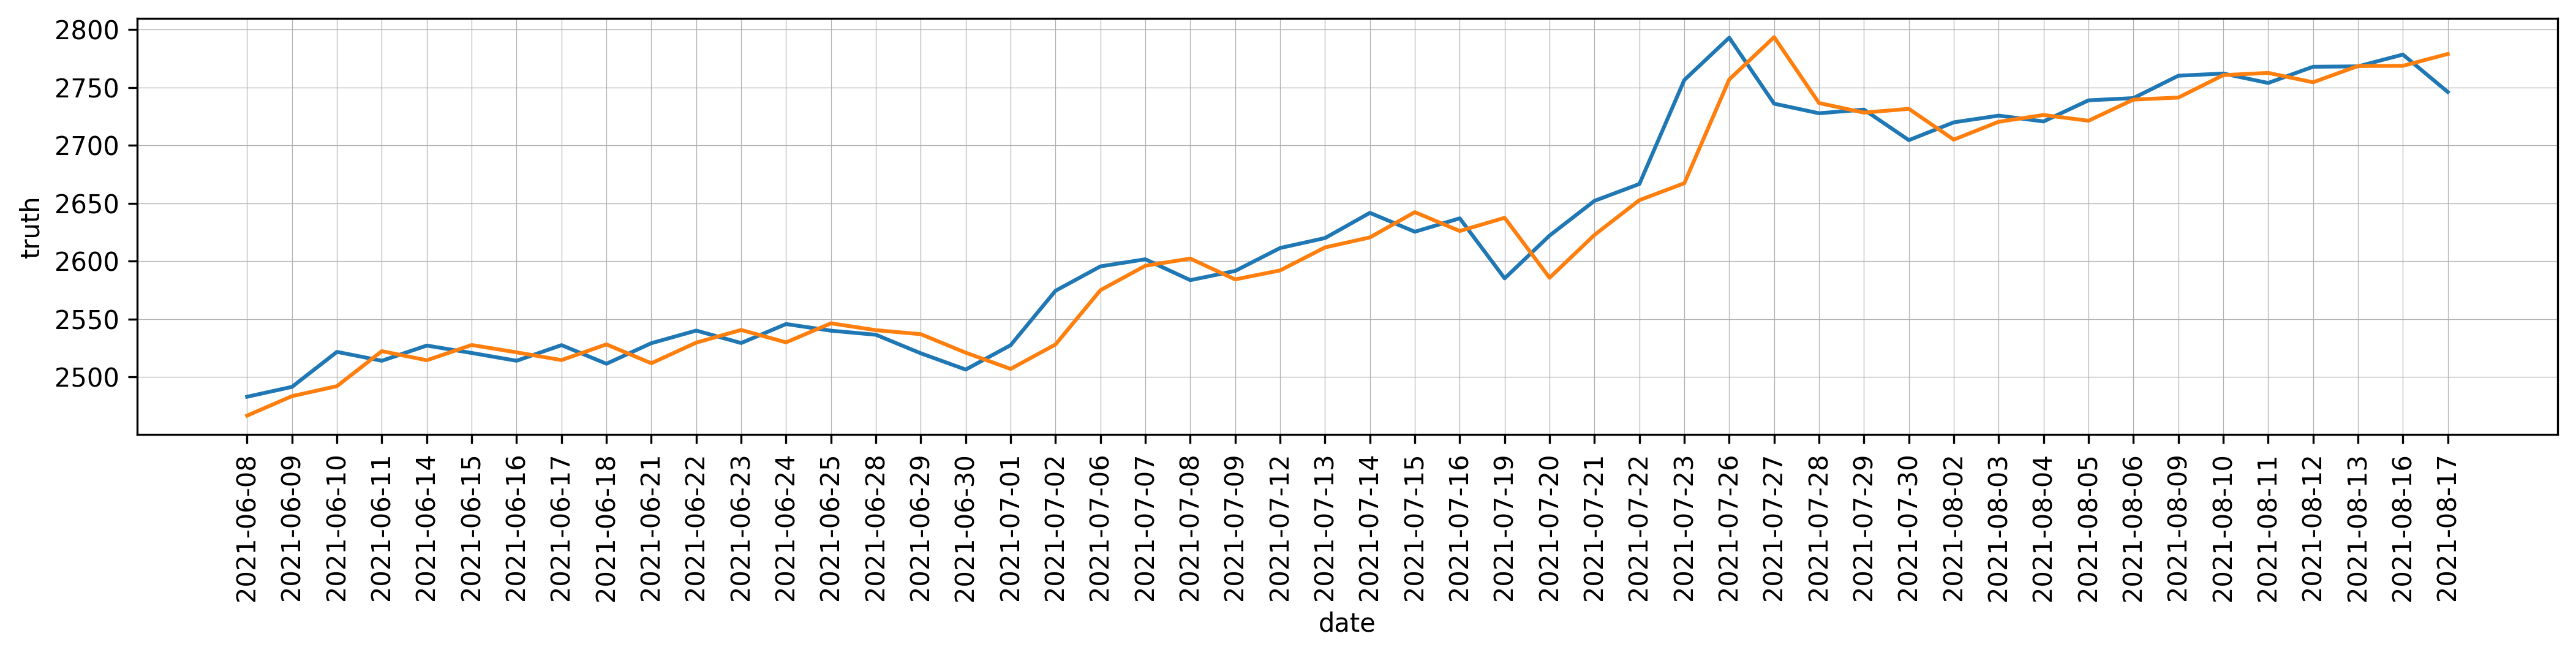

In [26]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=google_forecast.tail(50), x='date', y='truth')
sns.lineplot(data=google_forecast.tail(50), x='date', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [27]:

google_forecast.tail(10)

,date,predictions,truth
418,2021-08-04,2726.152093,2720.570068
419,2021-08-05,2721.170789,2738.800049
420,2021-08-06,2739.452309,2740.719971
421,2021-08-09,2741.181076,2760.040039
422,2021-08-10,2760.550712,2761.929932
423,2021-08-11,2762.486151,2753.790039
424,2021-08-12,2754.393771,2767.790039
425,2021-08-13,2768.442612,2768.120117
426,2021-08-16,2768.583645,2778.320068
427,2021-08-17,2778.828637,2746.010010


Not a good evaluation metric since we are lagging the truth. Maybe it's more apparent in drops

In [28]:
test_df['perc_change'] = (
    (test_df['adjusted_close'] - test_df['prev_adjusted_close']) * 100 / \
    test_df['prev_adjusted_close']).abs()
google_forecast = google_forecast.merge(test_df[['date', 'perc_change']], on='date')
google_forecast.sample()

/home/s/ss/323/q323ss/Renel/renal/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,predictions,truth,perc_change
222,2020-10-22,1593.814525,1615.329956,1.382022


In [29]:
performance = []
for perc_change in np.arange(0, 10, 0.5):
    test = google_forecast[google_forecast['perc_change'] > perc_change]
    performance.append({
        'perc_change': perc_change,
        'MAE':  mean_absolute_error(test['truth'], test['predictions']),
        'MAPE':  mean_absolute_percentage_error(test['truth'], test['predictions']),
        'count': test.shape[0]
    })
results = pd.DataFrame(performance)

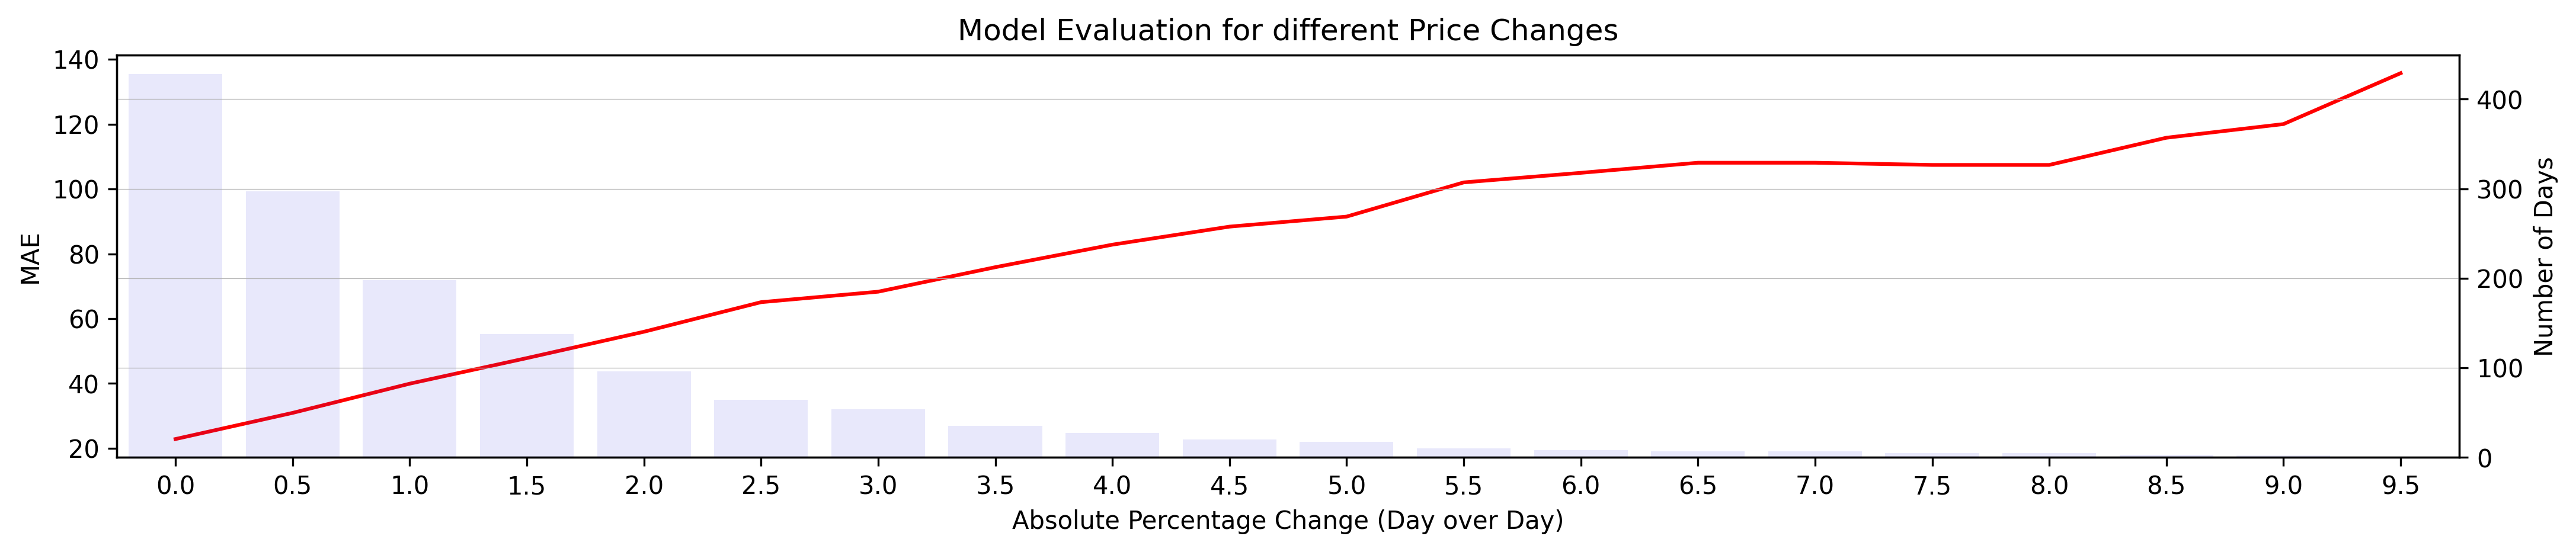

In [30]:

plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAE')

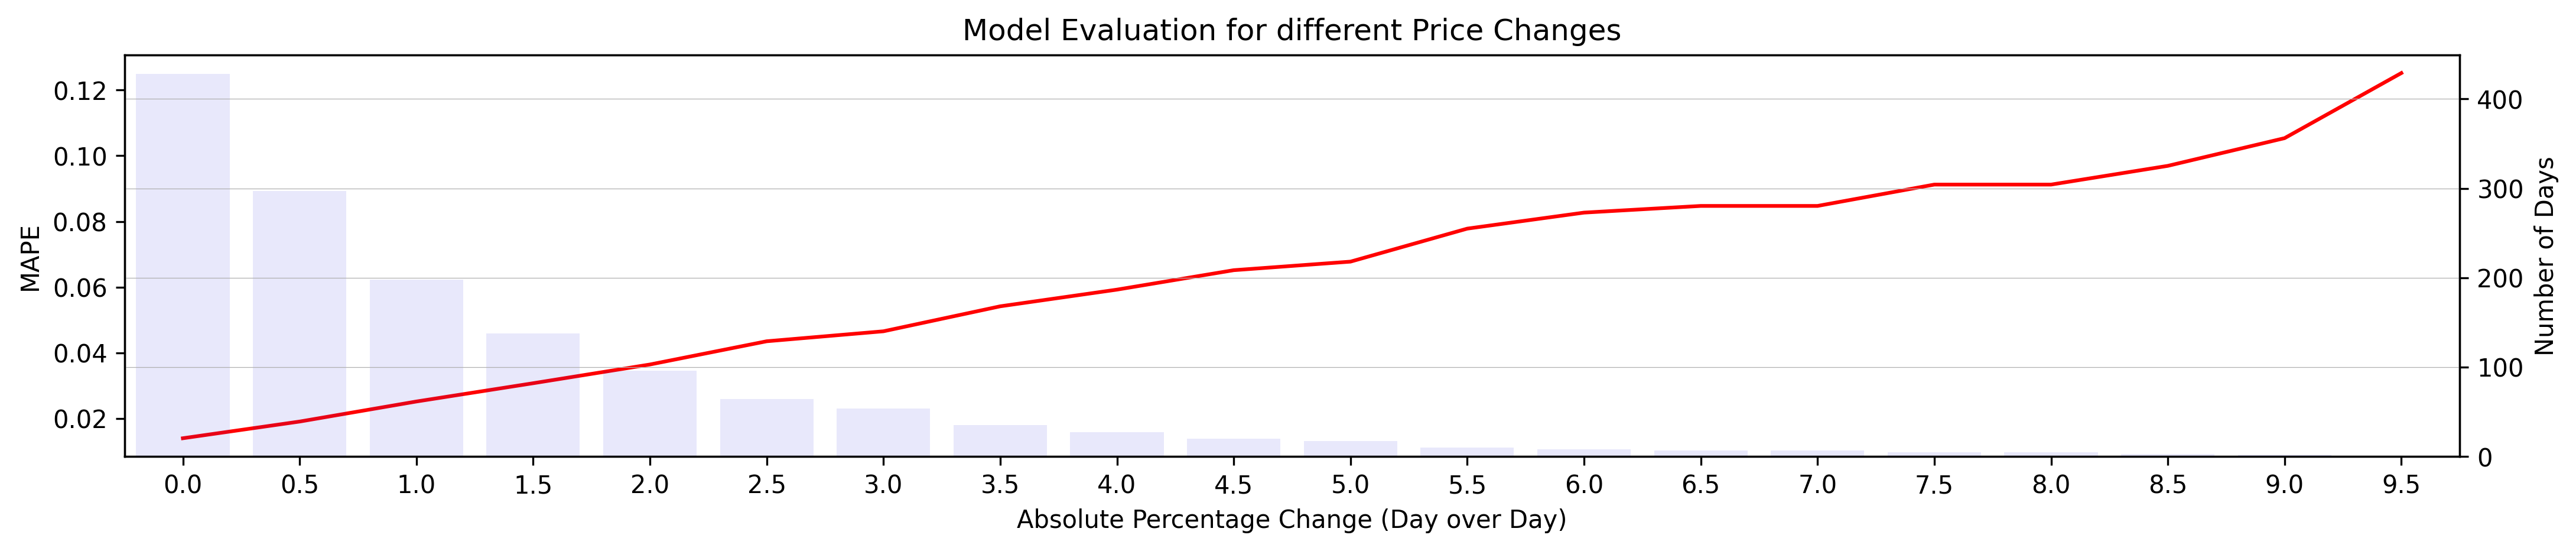

In [31]:

plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAPE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAPE')

##  Model Improvement: Adding Google Trend Data

In [48]:

from datetime import datetime, timedelta, date, time
import pandas as pd
import time

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError


def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [49]:
pytrend = TrendReq(hl='en-US')
keyword = 'google'
start = google['date'].min()
end = google['date'].max()

trends =get_daily_trend(pytrend, keyword, start=start, end=end)
trends_df = trends.reset_index().drop('overlap', axis=1)
trends_df.columns=['date', 'trend_score']
trends_df['date'] = trends_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
data = data.merge(trends_df, on='date')
data.sample()

,date,adjusted_close,prev_adjusted_close,prev_volume,day_of_week,trend_score
2855,2015-12-22,750.0,747.77002,1525700.0,1,76.0


In [50]:
categorical_features = []
numerical_features = ['trend_score']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [StandardScaler()]) for n in numerical_features]
cat = [([n], [OrdinalEncoder()]) for n in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1589.
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.50e-291
Time:                        18:04:01   Log-Likelihood:                -27175.
No. Observations:                3850   AIC:                         5.435e+04
Df Residuals:                    3848   BIC:                         5.437e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         485.7996      4.535    107.133      0.000     476.909     494.690
trend_score   180.7549      4.535     39.862      0.000     171.865     189.645
==============================================================================
Omnibus:                      775.259   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1318.345
Skew:                           1.382   Prob(JB):                    5.31e-287
Kurtosis:                       3.763   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


### Things to Try
Introduce a more complex model to pick up on more complex patterns
Add other predictors you think would be indicitive of stock prices
Perhaps you want to use more than 1 day of data in the features
Reduce the timeframe of training and see how effective say 1 month's of data is (instead of the over 5 years worth we are using)
Here is a lil template

In [55]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Perceptron

In [58]:
categorical_features = ['day_of_week']
numerical_features = ['prev_adjusted_close', 'prev_volume', 'trend_score']
label = 'adjusted_close'

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

num = [([n], [SimpleImputer()]) for n in numerical_features]
cat = [([c], [SimpleImputer(), OrdinalEncoder()]) for c in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

##########################################
#   Insert more complex model here!      #
##########################################

pipeline = Pipeline([
    ('preprocess', mapper),
    ('model', model)
])

pipeline.fit(X_train, y_train)
results = evaluation(pipeline, X_test, y_test)
print(f"MAE: ${round(results['MAE'], 2)}, MAPE: {round(results['MAPE'] * 100, 2)}%")

NameError: name 'model' is not defined

In [ ]:
evaluation(pipeline, X_train, y_train)

In [57]:
google_forecast = pd.DataFrame(data={'date': test_df['date'].reset_index().drop('index', axis=1)['date'],'predictions': results['y_pred'],'truth': y_test.reset_index().drop('index', axis=1)['adjusted_close']})

test_df['perc_change'] = ((test_df['adjusted_close'] - test_df['prev_adjusted_close']) * 100 /test_df['prev_adjusted_close']).abs()
google_forecast = google_forecast.merge(test_df[['date', 'perc_change']], on='date')

performance = []
for perc_change in np.arange(0, 10, 0.5):
    test = google_forecast[google_forecast['perc_change'] > perc_change]
    performance.append({
        'perc_change': perc_change,
        'MAE':  mean_absolute_error(test['truth'], test['predictions']),
        'MAPE':  mean_absolute_percentage_error(test['truth'], test['predictions']),
        'count': test.shape[0]
    })
results = pd.DataFrame(performance)

TypeError: 'RegressionResultsWrapper' object is not subscriptable